In [ ]:
!pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf.__version__)

2.6.3


In [ ]:
data_dir = '../input/all-brain-datset/all_dataset'
batch_size=32
image_size=224

In [ ]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.8,0.1,0.1))

Copying files: 3264 files [00:11, 285.38 files/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/train",
  shuffle=True,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 2609 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/val",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 325 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/test",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 330 files belonging to 4 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [ ]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

-1.0 0.9511


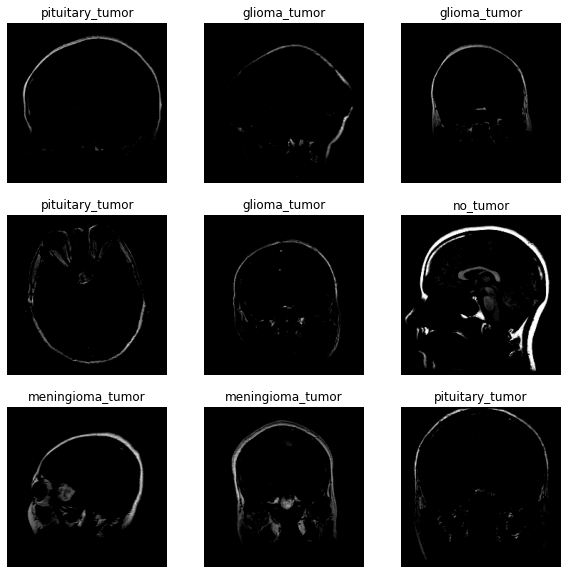

In [ ]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-1.0 0.9511


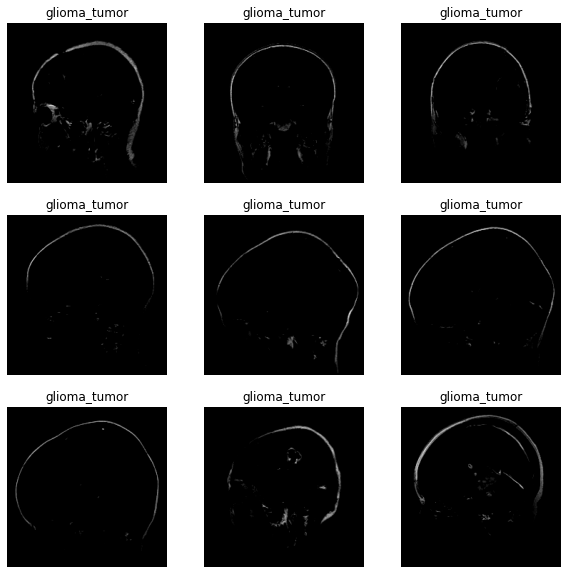

In [ ]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

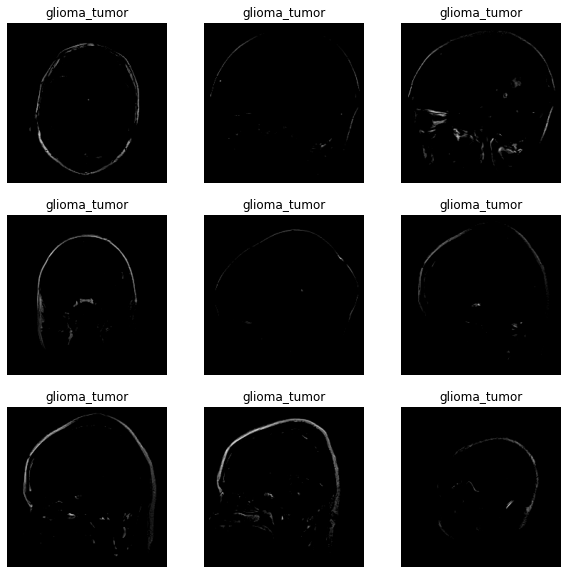

In [ ]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [ ]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(7,7)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [ ]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
model =  MobileNetV2(weights=None,include_top=True,input_shape=(image_size,image_size,3),alpha=1, classifier_activation='softmax',classes=4)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized,  validation_data=(val_ds_normalized), epochs=25)

Train Mobilenetv2 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 22s 201ms/step - loss: 1.1049 - accuracy: 0.5282 - val_loss: 1.3681 - val_accuracy: 0.2831
Epoch 2/25
82/82 [==============================] - 17s 206ms/step - loss: 0.7836 - accuracy: 0.6738 - val_loss: 1.3678 - val_accuracy: 0.2769
Epoch 3/25
82/82 [==============================] - 15s 182ms/step - loss: 0.6238 - accuracy: 0.7512 - val_loss: 1.4162 - val_accuracy: 0.2769
Epoch 4/25
82/82 [==============================] - 16s 186ms/step - loss: 0.4461 - accuracy: 0.8302 - val_loss: 1.6196 - val_accuracy: 0.2769
Epoch 5/25
82/82 [==============================] - 15s 181ms/step - loss: 0.3884 - accuracy: 0.8563 - val_loss: 1.8142 - val_accuracy: 0.2769
Epoch 6/25
82/82 [==============================] - 16s 191ms/step - loss: 0.2862 - accuracy: 0.8931 - val_loss: 2.3442 - val_accuracy: 0.2769
Epoch 7/25
82/82 [==============================] - 15s 180ms/step - loss: 0.2397 - accuracy: 0.9153 - 

Test Mobilenetv2 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00        94
meningioma_tumor       0.00      0.00      0.00        95
        no_tumor       0.15      1.00      0.26        50
 pituitary_tumor       0.00      0.00      0.00        91

        accuracy                           0.15       330
       macro avg       0.04      0.25      0.07       330
    weighted avg       0.02      0.15      0.04       330



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


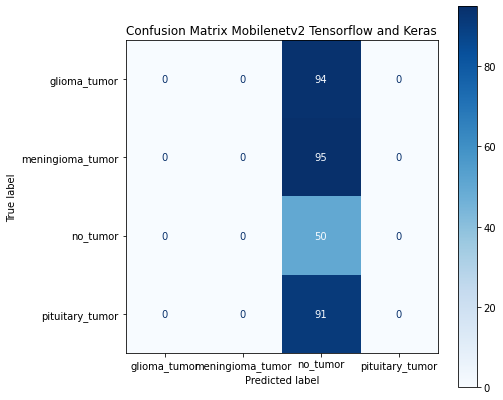

In [ ]:
y_pred_mobilenet_v2 = model.predict(test_ds_normalized)
display_report_and_matrix(y_pred_mobilenet_v2, 'Mobilenetv2')

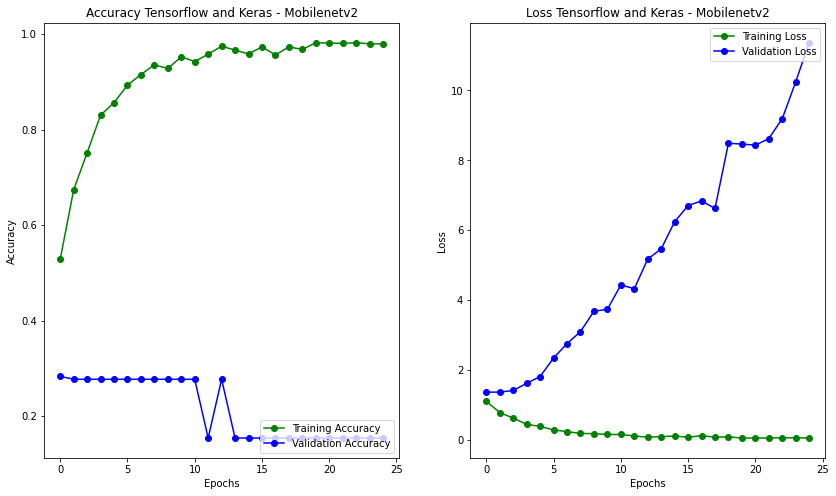

In [ ]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [ ]:
from tensorflow.keras.applications import DenseNet121 
model_densenet = DenseNet121(weights=None,include_top=True,input_shape=(image_size,image_size,3),classes=4)

In [ ]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train DenseNet121 Tensorflow and Keras')
history_densenet = model_densenet.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train DenseNet121 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 35s 269ms/step - loss: 1.0322 - accuracy: 0.6006 - val_loss: 2.5910 - val_accuracy: 0.2923
Epoch 2/25
82/82 [==============================] - 21s 245ms/step - loss: 0.8005 - accuracy: 0.6742 - val_loss: 8.7056 - val_accuracy: 0.3200
Epoch 3/25
82/82 [==============================] - 20s 239ms/step - loss: 0.6920 - accuracy: 0.7298 - val_loss: 1.4953 - val_accuracy: 0.3692
Epoch 4/25
82/82 [==============================] - 20s 239ms/step - loss: 0.6249 - accuracy: 0.7570 - val_loss: 4.0273 - val_accuracy: 0.4062
Epoch 5/25
82/82 [==============================] - 21s 247ms/step - loss: 0.5616 - accuracy: 0.7834 - val_loss: 12.2585 - val_accuracy: 0.2000
Epoch 6/25
82/82 [==============================] - 20s 235ms/step - loss: 0.4818 - accuracy: 0.8271 - val_loss: 1.3431 - val_accuracy: 0.5477
Epoch 7/25
82/82 [==============================] - 21s 242ms/step - loss: 0.4129 - accuracy: 0.8386 -

Test DenseNet121 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.80      0.86        94
meningioma_tumor       0.87      0.93      0.90        95
        no_tumor       0.72      0.84      0.78        50
 pituitary_tumor       0.98      0.97      0.97        91

        accuracy                           0.89       330
       macro avg       0.87      0.88      0.88       330
    weighted avg       0.89      0.89      0.89       330



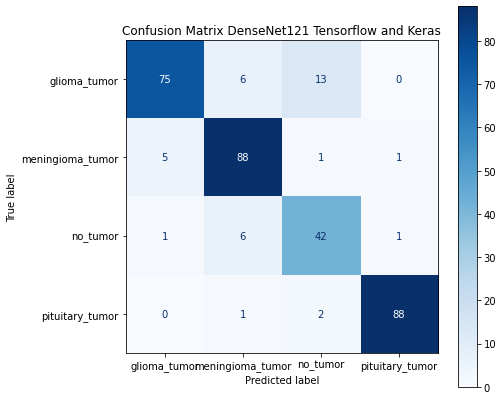

In [ ]:
y_pred_densenet = model_densenet.predict(test_ds_normalized)
display_report_and_matrix(y_pred_densenet, 'DenseNet121')

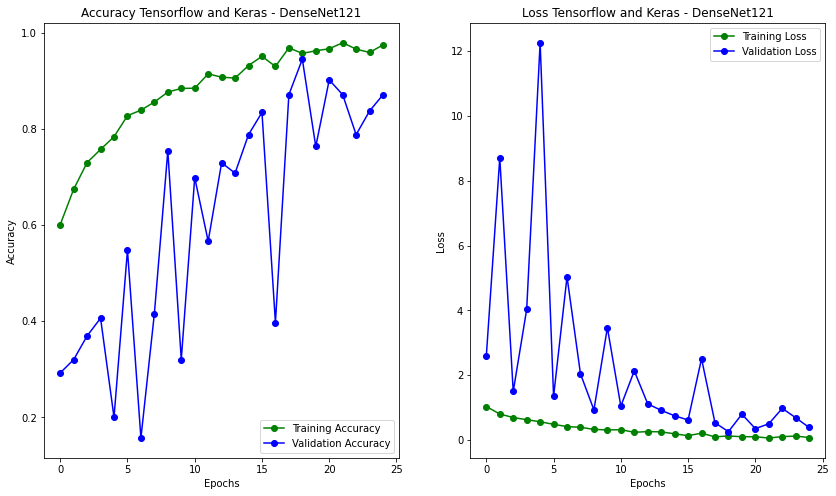

In [ ]:
display_plot(history_densenet, 'DenseNet121')

In [ ]:
from tensorflow.keras.applications import ResNet50 
model_resnet50 =  ResNet50(weights=None,include_top=True,input_shape=(image_size,image_size,3), classifier_activation='softmax',classes=4)

In [ ]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Resnet50 Tensorflow and Keras')
history_resnet50 = model_resnet50.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train Resnet50 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 26s 229ms/step - loss: 1.3583 - accuracy: 0.5665 - val_loss: 3.2074 - val_accuracy: 0.1323
Epoch 2/25
82/82 [==============================] - 16s 194ms/step - loss: 0.8801 - accuracy: 0.6685 - val_loss: 2.1358 - val_accuracy: 0.2215
Epoch 3/25
82/82 [==============================] - 16s 195ms/step - loss: 0.6829 - accuracy: 0.7501 - val_loss: 1.8159 - val_accuracy: 0.3754
Epoch 4/25
82/82 [==============================] - 17s 196ms/step - loss: 0.5767 - accuracy: 0.7827 - val_loss: 1.5103 - val_accuracy: 0.4646
Epoch 5/25
82/82 [==============================] - 18s 211ms/step - loss: 0.4854 - accuracy: 0.8153 - val_loss: 1.8972 - val_accuracy: 0.5046
Epoch 6/25
82/82 [==============================] - 17s 197ms/step - loss: 0.4072 - accuracy: 0.8559 - val_loss: 1.4291 - val_accuracy: 0.5569
Epoch 7/25
82/82 [==============================] - 16s 194ms/step - loss: 0.3398 - accuracy: 0.8796 - val

Test ResNet50 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.48      0.62        94
meningioma_tumor       0.84      0.80      0.82        95
        no_tumor       0.46      0.80      0.58        50
 pituitary_tumor       0.85      0.95      0.90        91

        accuracy                           0.75       330
       macro avg       0.76      0.76      0.73       330
    weighted avg       0.79      0.75      0.75       330



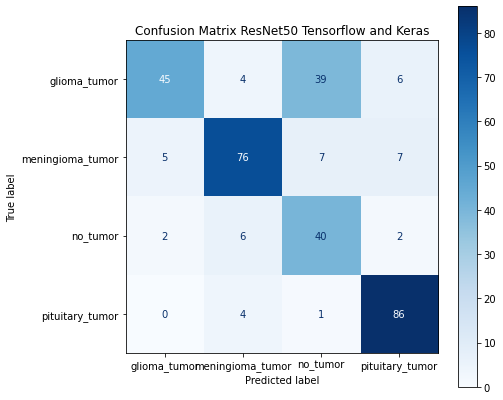

In [ ]:
y_pred_resnet50 = model_resnet50.predict(test_ds_normalized)
display_report_and_matrix(y_pred_resnet50, 'ResNet50')

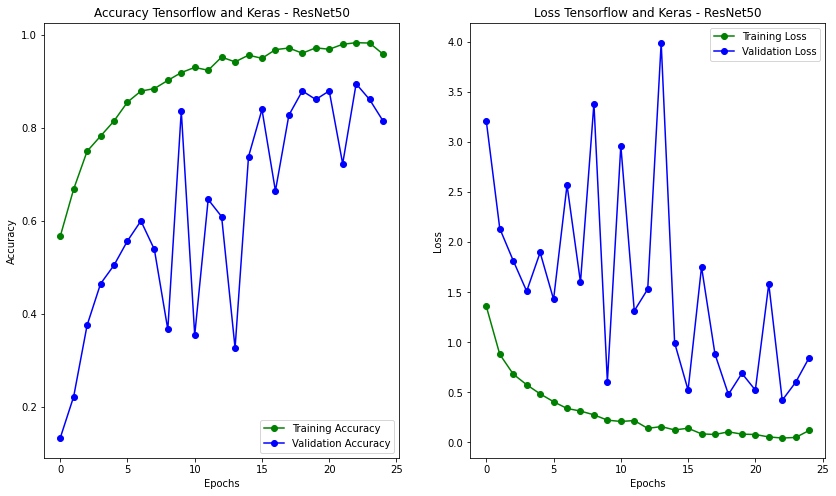

In [ ]:
display_plot(history_resnet50, 'ResNet50')